In [30]:
# Generic imports
#%%
import os
import random
import shutil
import progress.bar
from   datetime import datetime
from scipy.stats import qmc
import pandas as pd


import shapes
import meshes
import importlib

importlib.reload(shapes)
importlib.reload(meshes)

from shapes import *
from meshes import *

### ************************************************
### Generate full dataset
# Parameters
def generate_samples(numero_samples,n_base, latin_gen_bool):
    n_sampling_pts = 20
    mesh_domain    = False
    plot_pts       = True
    show_quadrants = True
    n_shapes       = numero_samples
    time           = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')
    dataset_dir    = 'dataset_'+time+'/'
    mesh_dir       = dataset_dir+'meshes/'
    img_dir        = dataset_dir+'images/'
    det_img_dir    = dataset_dir+'det_images/'
    bit_img_dir    = dataset_dir+'bit_images/'
    save_det_plot = False

    filename       = 'shape'
    magnify        = 1.0
    max_radius = (2)**0.5
    xmin           =-2.0
    xmax           = 2.0
    ymin           =-2.0
    ymax           = 2.0
    n_tri_max      = 5000
    n_pts = n_base

    ### generate latin hypercube points in the defined space
    equ_dim_lim = 1.5

    if latin_gen_bool != False:
        latin_gen = qmc.LatinHypercube(d=n_pts*2)
        latin_gen = latin_gen.random(n=n_shapes)
        latin_gen = equ_dim_lim * latin_gen

        latin_gend2 = qmc.LatinHypercube(d=n_pts*2)
        latin_gend2 = latin_gend2.random(n=n_shapes)
        latin_gend2 = latin_gend2 * 0.9
        radius_tot = latin_gend2.reshape(-1,n_shapes,n_pts)
        edgy_tot   = latin_gend2.reshape(-1,n_shapes,n_pts)
    else:
        latin_gen = False


    # Create directories if necessary
    if not os.path.exists(mesh_dir):
        os.makedirs(mesh_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    if not os.path.exists(det_img_dir):
        os.makedirs(det_img_dir)
    if not os.path.exists(bit_img_dir):
        os.makedirs(bit_img_dir)

    # Generate dataset
    bar = progress.bar.Bar('Generating shapes', max=n_shapes)
    df = pd.DataFrame(columns=['curve_points', 'area', 'perimeter','bitmap'])

    for i in range(0,n_shapes):
        generated = False
        while (not generated):
            if not latin_gen_bool:
                #n_pts  = random.randint(3, 7)
                radius = np.random.uniform(0.0, .9, size=n_pts)
                edgy   = np.random.uniform(0.0, .9, size=n_pts)
            else:
                radius = radius_tot[0,i,:]
                edgy   = radius_tot[1,i,:]

            shape  = Shape(filename+'_'+str(i),
                        None,
                        n_pts,
                        n_sampling_pts,
                        radius,
                        edgy,
                        save_det_plot = save_det_plot)
            
            shape.generate(magnify=1.0,
                        xmin=xmin,
                        xmax=xmax,
                        ymin=ymin,
                        ymax=ymax,
                        latin_gen = latin_gen)
            
            if save_det_plot:
                img  = filename+'_'+str(i)+"det_plot"+'.png'
                shutil.move(img,  det_img_dir)
            
            shape.generate_bitmap()
            """
            img  = filename+'_'+str(i)+"bit"+'.png'
            shutil.move(img,  bit_img_dir)
            """

            new_rows = [{'curve_points': shape.curve_pts, 'area': shape.area, 'perimeter': shape.curve_length, "bitmap": shape.bitmap}]
            df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
            generated = True
            #meshed, n_tri = shape.mesh()
            """
            if (True):
                shape.generate_image(plot_pts=plot_pts,
                                    max_radius = max_radius,
                                    xmin=xmin,
                                    xmax=xmax,
                                    ymin=ymin,
                                    ymax=ymax,
                                    show_quadrants=True)
                img  = filename+'_'+str(i)+'.png'
                mesh = filename+'_'+str(i)+'.mesh'
                shutil.move(img,  img_dir)
                #shutil.move(mesh, mesh_dir)
                generated = True
            """
        bar.next()
    bit = df["bitmap"]
    curve = df["area"]
    # End bar
    bar.finish()
    return bit,df

    # %%


In [5]:
n_sampling_pts = 20
mesh_domain    = False
plot_pts       = True
show_quadrants = True
n_shapes       = 100
time           = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')
dataset_dir    = 'dataset_'+time+'/'
mesh_dir       = dataset_dir+'meshes/'
img_dir        = dataset_dir+'images/'
det_img_dir    = dataset_dir+'det_images/'
bit_img_dir    = dataset_dir+'bit_images/'
save_det_plot = False

filename       = 'shape'
magnify        = 1.0
max_radius = (2)**0.5
xmin           =-2.0
xmax           = 2.0
ymin           =-2.0
ymax           = 2.0
n_tri_max      = 5000
n_pts = 4

latin_gend2 = qmc.LatinHypercube(d=n_pts*2)
latin_gend2 = latin_gend2.random(n=n_shapes)
latin_gend2 = latin_gend2 * 0.9

In [40]:
list_mse_mean_f = np.array([])
list_mse_var_f = np.array([])


for i in range(100, 401, 100):
    list_mse_mean = np.array([])
    list_mse_var = np.array([])
    
    for j in range(5):
        bit, df1 = generate_samples(int(i), 4, True)
        stack1 = np.stack(bit.values)  # shape: (N, H, W)
        N = stack1.shape[0]

        # Compute MSE between each pair of images
        mse_matrix = np.zeros((N, N))
        for j in range(N):
            diff = stack1 - stack1[j]  # broadcasted difference
            mse_matrix[j] = np.mean(diff ** 2, axis=(1, 2))

        # Set diagonal to np.inf to ignore self-comparison
        np.fill_diagonal(mse_matrix, np.inf)

        # Find minimum MSE per image (to closest neighbor)
        min_mse_per_image = np.min(mse_matrix, axis=1)

        mean1 = np.mean(min_mse_per_image)
        var1 = np.var(min_mse_per_image)

        list_mse_mean = np.append(list_mse_mean, mean1)
        list_mse_var = np.append(list_mse_var, var1)

    list_mse_mean_f = np.append(list_mse_mean_f, list_mse_mean.mean())
    list_mse_var_f = np.append(list_mse_var_f, list_mse_var.var())


/var/folders/9p/c80ms72x1zq5xk4ppbknqzlm0000gn/T/ipykernel_52285/2382610796.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
/var/folders/9p/c80ms72x1zq5xk4ppbknqzlm0000gn/T/ipykernel_52285/2382610796.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
/var/folders/9p/c80ms72x1zq5xk4ppbknqzlm0000gn/T/ipykernel_52285/2382610796.py:117: FutureWarning: The behavior 

In [41]:
list_mse_mean_r = np.array([])
list_mse_var_r = np.array([])


for i in range(100, 401, 100):
    list_mse_mean = np.array([])
    list_mse_var = np.array([])
    
    for j in range(5):
        bit, df1 = generate_samples(int(i), 4, False)
        stack1 = np.stack(bit.values)  # shape: (N, H, W)
        N = stack1.shape[0]

        # Compute MSE between each pair of images
        mse_matrix = np.zeros((N, N))
        for j in range(N):
            diff = stack1 - stack1[j]  # broadcasted difference
            mse_matrix[j] = np.mean(diff ** 2, axis=(1, 2))

        # Set diagonal to np.inf to ignore self-comparison
        np.fill_diagonal(mse_matrix, np.inf)

        # Find minimum MSE per image (to closest neighbor)
        min_mse_per_image = np.min(mse_matrix, axis=1)

        mean1 = np.mean(min_mse_per_image)
        var1 = np.var(min_mse_per_image)

        list_mse_mean = np.append(list_mse_mean, mean1)
        list_mse_var = np.append(list_mse_var, var1)


    list_mse_mean_r = np.append(list_mse_mean_r, list_mse_mean.mean())
    list_mse_var_r = np.append(list_mse_var_r, list_mse_var.var())


/var/folders/9p/c80ms72x1zq5xk4ppbknqzlm0000gn/T/ipykernel_52285/2382610796.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
/var/folders/9p/c80ms72x1zq5xk4ppbknqzlm0000gn/T/ipykernel_52285/2382610796.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
/var/folders/9p/c80ms72x1zq5xk4ppbknqzlm0000gn/T/ipykernel_52285/2382610796.py:117: FutureWarning: The behavior 

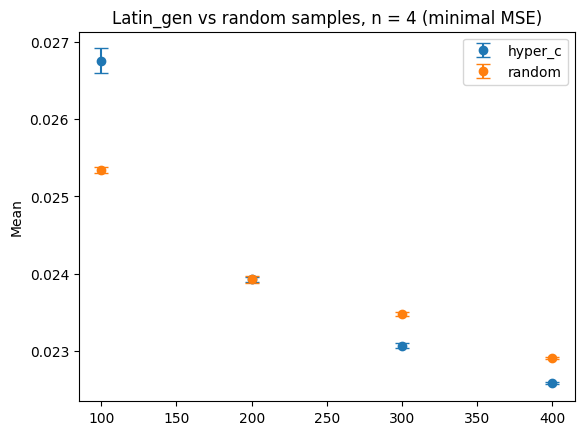

In [42]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

means = list_mse_mean_f
variances = list_mse_var_f
std_devs = np.sqrt(variances)

# 95% confidence interval
error = 1.96 * std_devs

x = np.linspace(100,400,4)
plt.errorbar(x, means, yerr=error, fmt='o', capsize=5, label = "hyper_c")


means = list_mse_mean_r
variances = list_mse_var_r
std_devs = np.sqrt(variances)

# 95% confidence interval
error = 1.96 * std_devs

x = np.linspace(100,400,4)
plt.errorbar(x, means, yerr=error, fmt='o', capsize=5, label = "random")
plt.ylabel('Mean')
plt.title('Latin_gen vs random samples, n = 4 (minimal MSE)')
plt.legend()
plt.show()


In [28]:
latin_gend2.reshape(-1,n_shapes,n_pts)[0,1,:]

array([0.13173789, 0.49552502, 0.0678177 , 0.77374068])

In [29]:
latin_gend2.reshape(-1,n_shapes,n_pts).shape

(2, 100, 4)